<a href="https://colab.research.google.com/github/vukovic-marko/projekat-nm/blob/master/model_implementation_and_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.corpus import stopwords
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Layer, Embedding, Input, GRU, Bidirectional, TimeDistributed, Dense, Dropout
from keras import Model
from keras import initializers
import keras.backend as K
import matplotlib.pyplot as plt

In [ ]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
pickled_sampled_dataframe_path = '/content/drive/My Drive/df.pkl'
glove_path = '/content/drive/My Drive/glove.6B.100d.txt'

In [ ]:
df = pd.read_pickle(pickled_sampled_dataframe_path)

In [ ]:
def convertInputSentences(review, stopWords):
  lemmatizer = WordNetLemmatizer()

  retString = ''
  
  sentence_tokens = sent_tokenize(review)

  for sentence in sentence_tokens:
    word_tokens = word_tokenize(sentence)
    sentence_new = [(idx, lemmatizer.lemmatize(word.lower())) for idx, word in enumerate(word_tokens) if word.lower() not in stopWords and word.isalnum()]

    tempList = [word[1] for word in sentence_new]
    retString = retString + ' '.join(tempList) + ' . '
  
  return retString

In [ ]:
df_processed = df.copy()

stopWords = stopwords.words('english')

In [ ]:
df_processed['sentences'] = df_processed['sentences'].map(lambda x: convertInputSentences(x, stopWords))

In [ ]:
#optimizovati parametre

MAX_SENTENCE_NUM = 30 #148 #9 
MAX_WORD_NUM = 20 #10 #40 
MAX_FEATURES = 200000
EMBED_SIZE = 100

In [ ]:
texts = []
for i in range(len(df_processed)):
  s = df_processed['sentences'].iloc[i]
  s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])
  texts.append(s)

tokenizer = Tokenizer(num_words=MAX_FEATURES, lower=True, oov_token=None)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

print('Number of tokens: ' + str(len(word_index)))

Number of tokens: 102523


In [ ]:
embeddings_index = {}
with open(glove_path, encoding='utf8') as file:
  for line in file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

min_wordCount = 2
absent_words = 0
small_words = 0

embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
word_counts = tokenizer.word_counts
for word, i in word_index.items():
  if word_counts[word] > min_wordCount:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
    else:
      absent_words += 1
  else:
    small_words += 1

print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)),
      '% of total words')
print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(word_index)),
      '% of total words')
print(str(len(word_index)-small_words-absent_words) + ' words to proceed.')

Total absent words are 8537 which is 8.33 % of total words
Words with 2 or less mentions 49838 which is 48.61 % of total words
44148 words to proceed.


In [ ]:
def split_df(dataframe, column_name, training_split, validation_split, test_split):
  if training_split + validation_split + test_split != 1.0:
    raise ValueError('Split parameter sum should be 1.0')
  
  total = len(dataframe.index)

  train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split)).reset_index(drop=True).set_index('index')
  train = train.sample(frac=1)
  temp_df = dataframe.drop(train.index)
  validation = temp_df.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=validation_split/(test_split+validation_split))).reset_index(drop=True).set_index('index')
  validation = validation.sample(frac=1)
  test = temp_df.drop(validation.index)
  test = test.sample(frac=1)

  print('Total: ', len(dataframe))
  print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
  print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))
  print('Test:', len(test), ', Percentage: ', len(test)/len(dataframe))

  return train, validation, test

In [ ]:
train, validation, test = split_df(df_processed, 'is_spoiler',0.8,0.1,0.1)

Total:  100000
Training:  80000 , Percentage:  0.8
Validation:  10000 , Percentage:  0.1
Test: 10000 , Percentage:  0.1


In [ ]:
def prepare_dataset_for_training(data):
  lista_svi = []
  for review in data.sentences.values:
    lista_review = []
    for sentence in review.split('.')[:-1]:
      lista = []
      for word in sentence.split(' '):
        if word != '':
          lista.append(word_index[word]) 
      lista_review.append(lista)
    lista_svi.append(lista_review)

  padded_list = []
  for sequence in lista_svi:
    padded_list.append(pad_sequences(sequence, maxlen=MAX_WORD_NUM, padding='post'))

  x = np.zeros((len(data), MAX_SENTENCE_NUM, MAX_WORD_NUM), dtype='int32')

  for i in range(len(padded_list)):
    for j in range(len(padded_list[i])):
      if j < MAX_SENTENCE_NUM:
        x[i,j] = np.array(padded_list[i][j])

  y = np.zeros((len(data), 2), dtype='int32')
  for i in range(len(data.is_spoiler)):
    if data.is_spoiler.iloc[i]:
      y[i] = np.array([0,1])
    else:
      y[i] = np.array([1,0])
  
  return x, y

In [ ]:
x_train, y_train = prepare_dataset_for_training(train)
x_val, y_val = prepare_dataset_for_training(validation)
x_test, y_test = prepare_dataset_for_training(test)

In [ ]:
class Attention(Layer):
    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self._trainable_weights = [self.W, self.b, self.u]

        super(Attention, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix], input_length=MAX_WORD_NUM, trainable=False,name='word_embedding')

word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
word_sequences = embedding_layer(word_input)
word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_sequences)
word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 
word_att,word_coeffs = Attention(attention_dim=EMBED_SIZE,return_coefficients=True,name='word_attention')(word_dense)
wordEncoder = Model(inputs = word_input,outputs = word_att)

sent_input = Input(shape=(MAX_SENTENCE_NUM,MAX_WORD_NUM), dtype='int32',name='sent_input')
sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)
sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
sent_dense = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
sent_att,sent_coeffs = Attention(EMBED_SIZE,return_coefficients=True,name='sent_attention')(sent_dense)
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
preds = Dense(2, activation='softmax',name='output')(sent_drop)

model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
print(wordEncoder.summary())
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_input (InputLayer)      [(None, 20)]              0         
_________________________________________________________________
word_embedding (Embedding)   (None, 20, 100)           10252400  
_________________________________________________________________
word_gru (Bidirectional)     (None, 20, 100)           45600     
_________________________________________________________________
word_dense (Dense)           (None, 20, 100)           10100     
_________________________________________________________________
word_attention (Attention)   [(None, 100), (None, 20,  10200     
Total params: 10,318,300
Trainable params: 65,900
Non-trainable params: 10,252,400
_________________________________________________________________
None
Model: "functional_3"
_________________________________________________________________
Layer (typ

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
2500/2500 [==============================] - 62s 25ms/step - loss: 0.5235 - acc: 0.7343 - val_loss: 0.4886 - val_acc: 0.7587
Epoch 2/10
2500/2500 [==============================] - 60s 24ms/step - loss: 0.4753 - acc: 0.7668 - val_loss: 0.4651 - val_acc: 0.7793
Epoch 3/10
2500/2500 [==============================] - 61s 24ms/step - loss: 0.4530 - acc: 0.7829 - val_loss: 0.4633 - val_acc: 0.7734
Epoch 4/10
2500/2500 [==============================] - 61s 24ms/step - loss: 0.4293 - acc: 0.7948 - val_loss: 0.4600 - val_acc: 0.7833
Epoch 5/10
2500/2500 [==============================] - 61s 24ms/step - loss: 0.4076 - acc: 0.8100 - val_loss: 0.4737 - val_acc: 0.7791
Epoch 6/10
2500/2500 [==============================] - 61s 24ms/step - loss: 0.3825 - acc: 0.8241 - val_loss: 0.4654 - val_acc: 0.7935
Epoch 7/10
2500/2500 [==============================] - 61s 24ms/step - loss: 0.3546 - acc: 0.8407 - val_loss: 0.4777 - val_acc: 0.7794
Epoch 8/10
2500/2500 [==========================

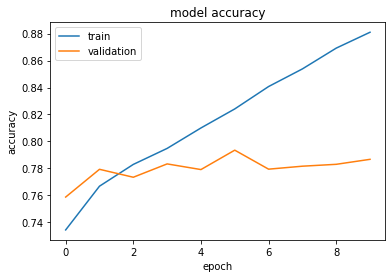

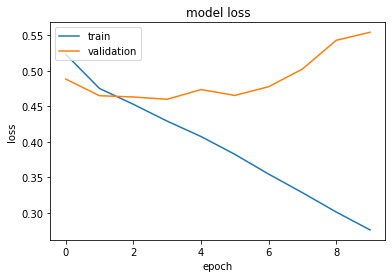

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(x=x_test, y=y_test, batch_size=None, verbose=1, sample_weight=None, steps=None)

313/313 [==============================] - 3s 10ms/step - loss: 0.5363 - acc: 0.7910


[0.5363017916679382, 0.7910000085830688]

In [ ]:
lista_svi = []
for review in df_processed.sentences.values:
  lista_review = []
  for sentence in review.split('.')[:-1]:
    lista = []
    for word in sentence.split(' '):
      if word != '':
        lista.append(word) 
    lista_review.append(lista)
  lista_svi.append(lista_review)

In [ ]:
max = 0
for review in lista_svi:
  if len(review) > max:
    max = len(review)

print(max)

148


In [ ]:
n_sent = 0
n_words = 0
for i in range(len(lista_svi)):
    sent = lista_svi[i]
    for satz in sent:
        n_words += len(satz)
    n_sent += len(sent)

print("Average number of words in each sentence: ",round(n_words/n_sent))
print("Average number of sentences in each document: ", round(n_sent/len(df_processed)))

Average number of words in each sentence:  8
Average number of sentences in each document:  17


In [ ]:
predictions = model.predict(x_test) 
print('First prediction:', predictions[0]) 

First prediction: [0.0325886 0.9674114]


In [ ]:
wrong_predictions = []
for i in range(len(predictions)):
  if (round(predictions[i][0]) == 1.0 and test.is_spoiler.iloc[i] == True) or (round(predictions[i][0]) == 0.0 and test.is_spoiler.iloc[i] == False):
    wrong_predictions.append([predictions[i], test.sentences.iloc[i], test.is_spoiler.iloc[i]])

Spominju se reči koje se često vezuju za spojlere, poput reči `death`, koja u ovom slučaju ne predstavlja spojler već autor samo opisuje stanje u datom istorijskom periodu

In [ ]:
wrong_predictions[1]

[array([0.70309854, 0.2969015 ], dtype=float32),
 'weird book . definitely going polarizing . holy shit book fantastic necessarily book enjoy typical sense definitely stay . book along dangerous girl got interested suspense genre . year since read book still haunt . read book midwinter lake tahoe yet atmosphere book drew well totally lost . dare obsession . dedication brutal world . power play hatred . drive competition boyfriend dating play competition teen world . twisted kind love . somehow incorporates brilliant suspenseful novel . obligatory section megan abbott mood tonal shift amazing . really really . love mood book love book make feel even know happening . book confusing weird utterly amazing . writing pretty without purple prose great . beth addy complete jerk yet somehow sympathized completely . complex character . even dislikable interest . relationship beth addy messed yet interesting read beth addy explicitly attracted looking back addy almost certainly attracted coach we

Spominje se reč `spoiler`. Autori kritika koje sadrže spojlere gotovo uvek i u samom tekstu navode da njihova kritika sadrži spojlere, pa je moguće da je attention mehanizam upravo toj reči dao veliki značaj, te je zato ova kritika pogrešno klasifikovana. Na to može uputiti i relativno niska verovatnoća koju je model za ovu predikciju dao, koja iznosi svega 64%. Takođe se spominje happy ending, pa je ova greška vezana i za prethodni tip grešaka.

In [ ]:
wrong_predictions[4]

[array([0.41204643, 0.5879535 ], dtype=float32),
 'star . thought book good . amazingly good like hoping going good nonetheless . felt like ezra cassidy relation small even though took good chunk book . like subtle way fell love like right face . ending predictable since strongly foreshadowed beginning book read enough contemporary book see coming . ending affect much typical type ending would going post spoiler sorry . high hope book . meet expectation thankful disappointment . ',
 False]

Autor u tekstu kritike često navodi reči `end` i `ending`. Iako je autor samo iskazivao svoja osećanja o završetku knjige, bez odavanja raspleta, model je ovaj komentar pogrešno detektovao kao spojler. Na grešaka ovog tipa jasno se vidi koliko je pojam spojlera teško definisati i ograničiti, pošto bi neki korisnici sigurno ovaj tip komentara smatrali spojlerom, zbog toga što se često na osnovu nečijih osećanja može pretpostaviti rasplet dela, posbno kod knjiga koje izlaze u nastavcima, pa su korisnici već upoznati sa likovima i zapletima.

In [ ]:
wrong_predictions[5]

[array([0.00160288, 0.99839705], dtype=float32),
 'star . like one much honest . thought cliff hanger end good whole double triple agent government conspiracy thing getting bit old . see may frame mind currently . maybe volume . ',
 False]